# Package settings

In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

import numpy as np

In [2]:
from few_shot.core import NShotTaskSampler
from few_shot.datasets import LogoNet

from few_shot.protonet import *
from few_shot.core import *
from few_shot.models import ResNet18

In [3]:
import os

In [4]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

# Parameter settings

In [5]:
n_test = 5

k_test = 70
k_test2 = 35

q_test = 5

evaluation_episodes = 1
episodes_per_epoch = 1

dataset_class = LogoNet

covariance_embedding_dim = 256
embedding_dim = 256
distance = 'gaussian'
offset=1.0

# Create dataloaders

In [6]:
evaluation = dataset_class('evaluation')
evaluation_taskloader = DataLoader(
    evaluation,
    batch_sampler=NShotTaskSampler(evaluation, evaluation_episodes, n_test, k_test, q_test),
    num_workers=4
)

Indexing evaluation...


5219it [00:00, 196151.12it/s]


In [7]:
def create_nshot_task_label(k, q):
    """Creates an n-shot task label.
    Label has the structure:
        [0]*q + [1]*q + ... + [k-1]*q
    # Arguments
        k: Number of classes in the n-shot classification task
        q: Number of query samples for each class in the n-shot classification task
    # Returns
        y: Label vector for n-shot task of shape [q * k, ]
    """
    y = torch.arange(0, k, 1 / q).long()
    return y

In [8]:
def prepare_nshot_task(batch, k, q):
    x, y = batch
    x = x.double()
    # Create dummy 0-(num_classes - 1) label
    y = create_nshot_task_label(k, q)
    return x, y

## Load model

- gaussian proto k=35 trained network

### Proto model

In [9]:
path = '../../trained_models/mahanalobis_val/'
models = os.listdir(path)

In [10]:
models

['mahalanobis_val_large_k35.ckpt', 'mahanalobis_val.ckpt']

In [11]:
model35 = ResNet18(flatten = True).to(device, dtype=torch.float)
model35.load_state_dict(torch.load(os.path.join(path,models[1]), map_location=device))
model35.eval()

ResNet(
  (trunk): Sequential(
    (0): SimpleBlock(
      (C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (relu2): ReLU(inplace)
      (shortcut): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BNshortcut): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SimpleBlock(
      (C1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN2): BatchNorm2d(64, eps=1e-05, mome

In [12]:
model70 = ResNet18(flatten = True).to(device, dtype=torch.float)
model70.load_state_dict(torch.load(os.path.join(path,models[0]), map_location=device))
model70.eval()

ResNet(
  (trunk): Sequential(
    (0): SimpleBlock(
      (C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (relu2): ReLU(inplace)
      (shortcut): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BNshortcut): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SimpleBlock(
      (C1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN2): BatchNorm2d(64, eps=1e-05, mome

## Model

In [13]:
def proto_net_mahanalobis_final(model,x,y,n_shot,k_way,q_queries,distance,covariance_embedding_dim, embedding_dim, offset, support_first=None):
    # Embed all samples
    embeddings = model(x)

    # Samples are ordered by the NShotWrapper class as follows:
    # k lots of n support samples from a particular class
    # k lots of q query samples from those classes
    if support_first is None:
        support_first = embeddings[:n_shot*k_way]
    queries = embeddings[n_shot*k_way:]

    support, raw_covariance_matrix = torch.split(support_first, [embedding_dim, covariance_embedding_dim], dim=1)
    queries, _ = torch.split(queries, [embedding_dim, covariance_embedding_dim], dim=1)
    
    #calculate inverse covariance matrix with trainable softplus function
    #inv_covariance_matrix = simple_calculate_inverse_covariance_matrix(raw_covariance_matrix, offset, True)
    inv_covariance_matrix = calculate_inverse_covariance_matrix(raw_covariance_matrix, offset)
    
    _, S = compute_gaussian_prototypes(support,inv_covariance_matrix, k_way, n_shot, embedding_dim)
    prototypes = compute_prototypes(support,k_way, n_shot)
    
    # Calculate squared distances between all queries and all prototypes
    # Output should have shape (q_queries * k_way, k_way) = (num_queries, k_way)
    distances = pairwise_distances(queries, prototypes, distance, S)

    # Calculate log p_{phi} (y = k | x)
    log_p_y = (-distances).log_softmax(dim=1)
    
    # Prediction probabilities are softmax over distances
    y_pred = (-distances).softmax(dim=1)

    return distances, y_pred, support_first

In [14]:
def split_data(split,x,y):
    support_x = x[:n_test*k_test]
    support_y = y[:n_test*k_test]

    queries_x = x[n_test*k_test:]
    queries_y = y[:n_test*k_test]

    x1 = torch.cat((support_x[:n_test*split], queries_x[:n_test*split]),0)
    y1 = torch.cat((support_y[:n_test*split], queries_y[:n_test*split]),0)

    x2 = torch.cat((support_x[n_test*split:], queries_x[n_test*split:]),0)
    y2 = torch.cat((support_y[n_test*split:], queries_y[n_test*split:]),0)
    
    return(x1,y1,x2,y2)

# Compute distances

In [16]:
dist_accept35 = np.array([])
dist_rej35 = np.array([])
dist_accept70 = np.array([])
dist_rej70 = np.array([])

pred_accept = np.array([])
pred_rej = np.array([])

for i in range(250):
    print(i)
    for batch_index, batch in enumerate(evaluation_taskloader):
        with torch.no_grad():
        
            x,y = batch
        
            x1, y1, x2, y2 = split_data(35,x,y)
        
            x, y = prepare_nshot_task((x1,y1), k_test2, n_test)
        
            y = y.to(device)
            x = x.to(device, dtype=torch.float)
            
            #model35
            distances, y_pred, support_first1 = proto_net_mahanalobis_final(model35,x,y,n_test,k_test2,q_test,distance,covariance_embedding_dim, embedding_dim, offset)
            
            outcomes = torch.eq(distances.argmin(dim=-1), y)
            distances_new = distances[outcomes]
            dist_accept35 = np.concatenate([dist_accept35, torch.min(distances_new, dim=1)[0].cpu().data.numpy()])
                    
            #model70
            distances, y_pred, support_first2 = proto_net_mahanalobis_final(model70,x,y,n_test,k_test2,q_test,distance,covariance_embedding_dim, embedding_dim, offset)
            
            outcomes = torch.eq(distances.argmin(dim=-1), y)
            distances_new = distances[outcomes]
            dist_accept70 = np.concatenate([dist_accept70, torch.min(distances_new, dim=1)[0].cpu().data.numpy()])

            x, y = prepare_nshot_task((x2,y2), k_test2, n_test)
            x = x.to(device, dtype=torch.float)
            
            #model35
            distances_rej, y_pred_rej, _ = proto_net_mahanalobis_final(model35,x,y,n_test,k_test2,q_test,distance,covariance_embedding_dim, embedding_dim, offset, support_first1)
            dist_rej35 = np.concatenate([dist_rej35, torch.min(distances_rej, dim=1)[0].cpu().data.numpy()])
            
            #model70
            distances_rej, y_pred_rej, _ = proto_net_mahanalobis_final(model70,x,y,n_test,k_test2,q_test,distance,covariance_embedding_dim, embedding_dim, offset, support_first2)
            dist_rej70 = np.concatenate([dist_rej70, torch.min(distances_rej, dim=1)[0].cpu().data.numpy()])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


## Calculate acceptance/rejection rate numbers

In [17]:
def metric_maker(data, threshold, dist=True):
    if dist:
        return(len(data[data<threshold])/len(data))
    else:
        return(len(data[data>=threshold])/len(data))

In [18]:
numbering = np.arange(14, 38, 0.25)

In [19]:
aa = [metric_maker(dist_accept35, i) for i in numbering]
bb = [metric_maker(dist_rej35, i) for i in numbering]

In [20]:
cc = [metric_maker(dist_accept70, i) for i in numbering]
dd = [metric_maker(dist_rej70, i) for i in numbering]

## Plot that shows false acceptance versus true acceptance rate

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

- red is distance metric
- blue is probability metric
- green is from reptile model

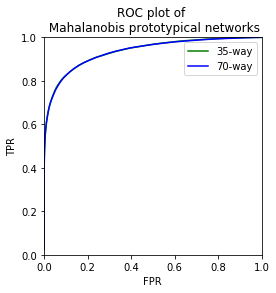

In [24]:
plt.plot(bb, aa, 'g', label='35-way')
plt.plot(dd, cc, 'b', label='70-way')
plt.axis([0, 1, 0, 1])
plt.title('ROC plot of \n Mahalanobis prototypical networks')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig('ROC_resnet_val_distance_new.jpg', dpi=1000)
plt.show()

# Comparison

In [15]:
k = [5,20,35,50,65,80,95]

In [16]:
def create_dataloader(evaluation_episodes, n_test, k_test, q_test):
    evaluation = dataset_class('evaluation')
    evaluation_taskloader = DataLoader(
        evaluation,
        batch_sampler=NShotTaskSampler(evaluation, evaluation_episodes, n_test, k_test, q_test),
        num_workers=4
    )
    return(evaluation_taskloader)

In [17]:
def categorical_accuracy(y, y_pred):
    return torch.eq(y_pred.argmax(dim=-1), y).sum().item() / y_pred.shape[0]

In [18]:
def get_accuracies(model, tasks, runs):
    pred = np.array([])
    std_v = np.array([])
    k_test = 5
    q_test = 5

    for i,num in enumerate(tasks):
        dataloader = create_dataloader(runs, 5, num, 5)
        print(i)
    
        final_test_accuracy = []
        for batch in dataloader:
            with torch.no_grad():
                x, y = prepare_nshot_task(batch, num, q_test)
                
                x = x.to(device, dtype=torch.float)
                y = y.to(device)
                
                    
                distances, y_pred, _ = proto_net_mahanalobis_final(model,x,y,n_test,num,q_test,distance,covariance_embedding_dim, embedding_dim, offset)
                test_acc = categorical_accuracy(y, y_pred)
                final_test_accuracy.append(test_acc)
        
        metaval_accuracies = np.array(final_test_accuracy)
        means = np.mean(metaval_accuracies, 0, keepdims=True)
        stds = np.std(metaval_accuracies, 0, keepdims=True)
        ci95 = 1.96*stds/np.sqrt(runs)
        
        pred = np.concatenate([pred,means])
        std_v = np.concatenate([std_v,ci95])
        
    return(pred,std_v)

In [19]:
pred35, stds35 = get_accuracies(model35, k, 200)
pred70, stds70 = get_accuracies(model70, k, 200)

5219it [00:00, 203427.99it/s]

Indexing evaluation...
0



5219it [00:00, 45971.90it/s]

Indexing evaluation...
1



5219it [00:00, 199931.25it/s]

Indexing evaluation...
2



5219it [00:00, 207957.98it/s]

Indexing evaluation...
3



5219it [00:00, 200013.46it/s]

Indexing evaluation...
4



5219it [00:00, 203649.42it/s]

Indexing evaluation...
5



5219it [00:00, 203801.10it/s]

Indexing evaluation...
6



5219it [00:00, 215319.95it/s]

Indexing evaluation...
0



5219it [00:00, 197590.58it/s]

Indexing evaluation...
1



5219it [00:00, 209214.11it/s]

Indexing evaluation...
2



5219it [00:00, 202070.29it/s]

Indexing evaluation...
3



5219it [00:00, 203320.29it/s]

Indexing evaluation...
4



5219it [00:00, 205921.49it/s]

Indexing evaluation...
5



5219it [00:00, 199586.72it/s]

Indexing evaluation...
6


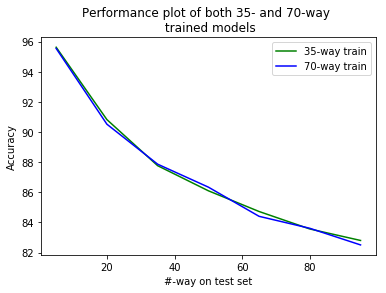

In [26]:
plt.plot(k, pred35*100, 'g', label='35-way train')
plt.plot(k, pred70*100, 'b', label='70-way train')
plt.title('Performance plot of both 35- and 70-way \n trained models')
plt.xlabel('#-way on test set')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracy_vs_high_way.jpg', dpi=1000)
plt.show()